In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define directories in the writable space
dataset_dir = "/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset"
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/test'

# Create train, validation, and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through each class folder and split images into train, validation, and test
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    if os.path.isdir(class_path):  # Ensure we only process folders
        # Create class-specific directories inside train, val, and test
        train_class_path = os.path.join(train_dir, class_name)
        val_class_path = os.path.join(val_dir, class_name)
        test_class_path = os.path.join(test_dir, class_name)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(val_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Get all image files in the current class folder
        all_images = [f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')]
        
        # Split the images into train (80%), validation (10%), and test (10%)
        train_images, temp_images = train_test_split(all_images, test_size=0.2, random_state=42)  # 80% train
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)  # 50% of remaining = 10% test, 10% val
        
        # Move the images to the corresponding train, val, and test folders
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_class_path, img))
        
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_class_path, img))
        
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_class_path, img))


In [15]:

# Data augmentation for training data
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize to [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation data, only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4729 images belonging to 40 classes.
Found 605 images belonging to 40 classes.
Found 611 images belonging to 40 classes.


In [16]:
# Load pre-trained ResNet50 model and add custom layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze ResNet50 layers


In [18]:
# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(40, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=x)

In [19]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [21]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]  # Add callbacks here
)

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 66s 378ms/step - accuracy: 0.0318 - loss: 3.7340 - val_accuracy: 0.0413 - val_loss: 3.6206 - learning_rate: 0.0010
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 52s 335ms/step - accuracy: 0.0410 - loss: 3.6183 - val_accuracy: 0.0612 - val_loss: 3.5557 - learning_rate: 0.0010
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 52s 333ms/step - accuracy: 0.0548 - loss: 3.5541 - val_accuracy: 0.0678 - val_loss: 3.5233 - learning_rate: 0.0010
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 52s 334ms/step - accuracy: 0.0562 - loss: 3.5132 - val_accuracy: 0.0893 - val_loss: 3.4933 - learning_rate: 0.0010
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 52s 333ms/step - accuracy: 0.0601 - loss: 3.5023 - val_accuracy: 0.0760 - val_loss: 3.4668 - learning_rate: 0.0010
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 52s 336ms/step - accuracy: 0.0651 - loss: 3.4663 - val_accuracy: 0.0826 - val_loss: 3.4574 - learning_rate: 0.0010
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 52s 335ms/step - accuracy: 0.0

In [23]:
# Fine-tuning: Unfreeze the ResNet50 layers after initial training
base_model.trainable = True

# Re-compile the model with a smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    epochs=10,  # Continue training for more epochs
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]  # Continue using callbacks
)

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 54s 347ms/step - accuracy: 0.1054 - loss: 3.4796 - val_accuracy: 0.0248 - val_loss: 88.8753 - learning_rate: 1.0000e-05
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 53s 340ms/step - accuracy: 0.2094 - loss: 2.9660 - val_accuracy: 0.0248 - val_loss: 33.2012 - learning_rate: 1.0000e-05
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 53s 342ms/step - accuracy: 0.3744 - loss: 2.3648 - val_accuracy: 0.0298 - val_loss: 8.9082 - learning_rate: 1.0000e-05
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 54s 346ms/step - accuracy: 0.5946 - loss: 1.7327 - val_accuracy: 0.0959 - val_loss: 3.9774 - learning_rate: 1.0000e-05
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 54s 346ms/step - accuracy: 0.7562 - loss: 1.1351 - val_accuracy: 0.3802 - val_loss: 2.4243 - learning_rate: 1.0000e-05
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 53s 343ms/step - accuracy: 0.8445 - loss: 0.7744 - val_accuracy: 0.7537 - val_loss: 1.0384 - learning_rate: 1.0000e-05
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 53s 

In [26]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.9490 - loss: 0.1739
Test accuracy: 0.9460


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


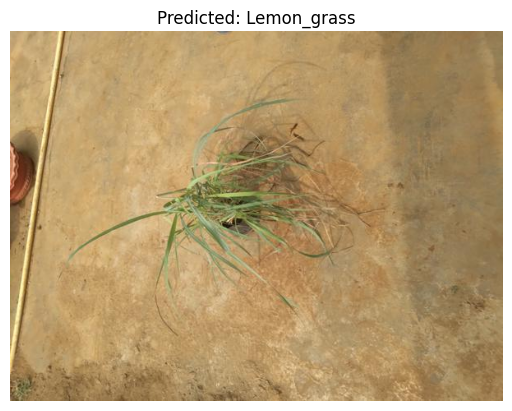

Predicted class: Lemon_grass


In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Load the image
    img_array = image.img_to_array(img)  # Convert to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image to [0, 1]
    return img_array

# Path to the image you want to predict (replace with your image path)
img_path = '/kaggle/working/test/Lemon_grass/477.jpg'

# Preprocess the image
img = load_and_preprocess_image(img_path)

# Make prediction
predictions = model.predict(img)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Get the class labels (from the test generator)
class_labels = list(validation_generator.class_indices.keys())

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Display the image and predicted label
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')  # Hide axis
plt.show()

print(f"Predicted class: {predicted_class_label}")


In [33]:

# Save the model to a file
model.save('/kaggle/working/plant_species_model.h5')

